In [76]:
from openai import OpenAI
import base64
import json
import re
import plotly.graph_objs as go
from dash.dependencies import Input, Output, State
import dash
from icecream import ic


from functions.nutrition_processing import *
%load_ext autoreload
%autoreload 2


### openai key
import os
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
api_key = os.getenv("API_KEY")
# Set the environment variable
os.environ["OPENAI_API_KEY"] = api_key
####

pd.set_option('display.max_columns', 100)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
  
# Path to your image
image_path = "/Users/jasperhajonides/Documents/Projects/website/dash_health_app/assets/images/20231228_Butter_Biscuit.png"

# Getting the base64 string
image = encode_image(image_path)

In [17]:
# add extra info
textprompt = None

protein_content = 0.3

prompt = (f"Lets play a game: If there is a food item in this picture: lets try to estimate the amount of amino acids this this food contains. We estimate it contains  {protein_content}g of protein. I know this is difficult but you it is critical you estimate a miligram value per amino acid. Only respond with  miligram values in this following json format table:"+
"""{"essential amino acids":{
        "histidine": , 
        "isoleucine" , 
        "leucine", 
        "lysine", 
        "methionine", 
        "phenylalanine", 
        "threonine", 
        "tryptophan", 
        "valine" },
"non essential amino acids":{
"alanine", 
"arginine", 
"asparagine", 
"aspartic acid", 
"cysteine", 
"glutamic acid", 
"glutamine", 
"glycine", 
"proline", 
"serine", 
"tyrosine",
    }
    } 
""")
if textprompt is not None:
    print('ADDING ADDITIONAL INSTRUCTIONS:::::::', textprompt)
    prompt = prompt + f""" Some additional information about this image is that it contains: {textprompt}"""


api_key = os.getenv("API_KEY")
client = OpenAI(api_key=api_key) 


In [112]:

response = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
        {
            "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt
            },
            {
            "type": "image_url",
            "image_url": {
                    "url": f"data:image/jpeg;base64,{image}",  # Assuming stored_image is just the base64 string
                    "detail": "low"

            }
            }
        ]
        }
    ],
    max_tokens=360,
)

In [113]:
text = response.choices[0].message.content
print(text)

There is a biscuit in the image. Unfortunately, without detailed nutritional information specific to this biscuit, it's not possible to accurately estimate the milligram values for each amino acid in a food item based only on the total protein content. However, if we assume a general distribution of amino acids in a common protein, we could provide a very rough estimate. Please note that the actual amino acid composition can vary widely depending on the type of protein and other ingredients in the biscuit. The following table attempts an estimation assuming the biscuit's protein is similar to a generic protein:

```
{
    "essential amino acids": {
        "histidine": 7.5, 
        "isoleucine": 15, 
        "leucine": 25, 
        "lysine": 20, 
        "methionine": 7.5, 
        "phenylalanine": 17.5, 
        "threonine": 15, 
        "tryptophan": 5, 
        "valine": 17.5
    },
    "non-essential amino acids": {
        "alanine": 15, 
        "arginine": 15, 
        "asparag

In [144]:
text = response.choices[0].message.content
print(text)

There is a biscuit in the image. Unfortunately, without detailed nutritional information specific to this biscuit, it's not possible to accurately estimate the milligram values for each amino acid in a food item based only on the total protein content. However, if we assume a general distribution of amino acids in a common protein, we could provide a very rough estimate. Please note that the actual amino acid composition can vary widely depending on the type of protein and other ingredients in the biscuit. The following table attempts an estimation assuming the biscuit's protein is similar to a generic protein:

```
{
    "essential amino acids": {
        "histidine": 7.5, 
        "isoleucine": 15, 
        "leucine": 25, 
        "lysine": 20, 
        "methionine": 7.5, 
        "phenylalanine": 17.5, 
        "threonine": 15, 
        "tryptophan": 5, 
        "valine": 17.5
    },
    "non-essential amino acids": {
        "alanine": 15, 
        "arginine": 15, 
        "asparag

In [168]:
# Remove comments, keeping '//' but removing the rest of the comment
response_text = re.sub(r'(?<=//).*?(?=\n)', '', response_text)
response_text = re.sub(r'//', '', response_text)

# Isolate the portion of the text following '```json'
json_section = extract_json_string(response_text)

# Find all matches of key-value pairs in JSON format
key_value_pairs = re.findall(r'"([^"]+)"\s*:\s*("[^"]+"|\d+|\d+\.\d+)', json_section)
# Build a dictionary from these key-value pairs
json_data = {}
# json_data['llm_output'] = response_text
for key, value in key_value_pairs:
    print(key, value)
    # Convert numeric values from strings to numbers
    if value.replace('.', '', 1).isdigit():
        value = float(value) if '.' in value else int(value)
    else:
        value = value.strip('"')

    json_data[key] = value

In [143]:
import re

def extract_json_string(text):
    # Use regular expression to match content within '```'
    match = re.search(r'```(.*?)```', text, re.DOTALL)
    if match:
        # Extract the content between the backticks
        json_string = match.group(1)
        return json_string
    else:
        # If there's no match, return an empty string
        return ""
    

# Example usage:
response_text = "The distribution of amino acids in milligrams:\n\n```\n{\n 'essential amino acids': {\n 'histidine': 7, \n 'isoleucine': 11, \n 'leucine': 23, \n 'lysine': 9, \n 'methionine': 5, \n 'phenylalanine': 14, \n 'threonine': 11, \n 'tryptophan': 3, \n 'valine': 13 \n },\n 'non-essential amino acids': {\n 'alanine': 10, \n 'arginine': 18, \n 'asparagine': 0, \n 'aspartic acid': 23, \n 'cysteine': 4, \n 'glutamic acid': 40, \n 'glutamine': 0, \n 'glycine': 8, \n 'proline': 11, \n 'serine': 13, \n 'tyrosine': 9\n }\n}\n```\n\nPlease note that these are approximate."
json_string = extract_json_string(response_text)
print(json_string)



{
 'essential amino acids': {
 'histidine': 7, 
 'isoleucine': 11, 
 'leucine': 23, 
 'lysine': 9, 
 'methionine': 5, 
 'phenylalanine': 14, 
 'threonine': 11, 
 'tryptophan': 3, 
 'valine': 13 
 },
 'non-essential amino acids': {
 'alanine': 10, 
 'arginine': 18, 
 'asparagine': 0, 
 'aspartic acid': 23, 
 'cysteine': 4, 
 'glutamic acid': 40, 
 'glutamine': 0, 
 'glycine': 8, 
 'proline': 11, 
 'serine': 13, 
 'tyrosine': 9
 }
}



In [195]:
json_data =  {'protein': 14.7, 'total fat': 68.5, 'carbohydrates': 3.3, 'sugar': 2.6, 'calories': 688.0, 'weight': 100.0, 'saturated fat': 7.47, 'unsaturated fat': 10.67, 'name': 'Walnuts, kernel only', 'meal_type': 'Breakfast'}
name = json_data['name']
weight = json_data['weight']

json_data.pop('meal_type', None) 
json_data.pop('weight', None) 
json_data.pop('name', None) 

json_string = json.dumps(json_data)


In [196]:
json_data

{'protein': 14.7,
 'total fat': 68.5,
 'carbohydrates': 3.3,
 'sugar': 2.6,
 'calories': 688.0,
 'saturated fat': 7.47,
 'unsaturated fat': 10.67}

In [348]:
name = 'Walnuts, kernel only'
weight = 100

prompt = (f"""I'd like to play a game and see if we can estimate a few food metrics of {weight}g of "{name}", we dont know much more about this food item, except for hte following:
{json_string}
Lets estimate values of the following metrics, we do not have a lab environment but can make a pretty good educated guess:""" +
"""{'glycemic index': ,
"essential amino acids":{
        "histidine": , 
        "isoleucine" , 
        "leucine", 
        "lysine", 
        "methionine", 
        "phenylalanine", 
        "threonine", 
        "tryptophan", 
        "valine" },
"non essential amino acids":{
"alanine", 
"arginine", 
"asparagine", 
"aspartic acid", 
"cysteine", 
"glutamic acid", 
"glutamine", 
"glycine", 
"proline", 
"serine", 
"tyrosine",
    }
    } 

Please output in json format, like the above, with a single float value for all json entries.
""")

weight = 100
name = 'Walnuts, kernel only'
prompt = (f"""Lets play a game: Lets see if we can estomate the following macros and nutrients from {weight}g of a standard "{name}" """+""" {
            'calories': , 
            'carbohydrates: , 
            'sugar': ,
            'fiber': ,
            'protein':  ,
            'total fat': , 
            'saturated fat': 
            'unsaturated fat': ,
            } Only output a single value per property, no ranges. And format output in a json."""
)

prompt = f"""Lets play a game: Lets see if we can estomate nutrients from {weight}g of a standard "{name}". Give me the numbers for the following variables:
          'calories', 'carbohydrates','protein','fat','saturated fat','unsaturated fat','sugar','glucose','fructose','lactose',galactose, 'glycemic index', fiber,'soluble fiber','insoluble fiber','iron','histidine','isoleucine', 'leucine', 'lysine', 'methionine','phenylalanine','threonine','tryptophan','valine'.
          please give the output in json format with the quantities in grams where possible. 
          """


from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106", #gpt-3.5-turbo-1106 "gpt-4" gpt-4-0613
  messages=[
    {
      "role": "user",
      "content": prompt
    }
  ],
  temperature=1,
  max_tokens=512,
  top_p=1,
  n=1,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={ "type": "json_object"},
)



In [349]:
json.loads(response.choices[0].message.content)

{'calories': 654,
 'carbohydrates': 13.7,
 'protein': 15.2,
 'fat': 65.2,
 'saturated fat': 6.1,
 'unsaturated fat': 58.8,
 'sugar': 2.6,
 'glucose': 0.2,
 'fructose': 1.9,
 'lactose': 0,
 'galactose': 0,
 'glycemic index': 15,
 'fiber': 6.7,
 'soluble fiber': 1.7,
 'insoluble fiber': 4.9,
 'iron': 2.9,
 'histidine': 0.4,
 'isoleucine': 0.7,
 'leucine': 1.3,
 'lysine': 0.4,
 'methionine': 0.3,
 'phenylalanine': 0.8,
 'threonine': 0.5,
 'tryptophan': 0.2,
 'valine': 0.8}

In [331]:
schema = {
  "type": "object",
  "properties": {
      
    "ingredients": {
      "type": "array",
      "items": {
        "type": "object",
        "properties": {
          "name": { "type": "string" },
          "unit": { 
            "type": "string",
            "enum": ["grams", "milligrams"]
          },
          "amount": { "type": "number" }
        },
        "required": ["name", "unit", "amount"]
      }
    },

    "details": {
      "type": "array",
      "description": "Steps to prepare the recipe (no numbering)",
      "items": { "type": "string" }
    },
   
  },
  "required": ["ingredients", "details"]
}
completion = client.chat.completions.create(
  model="gpt-4-0613",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Provide me all the nutritional macros, all essential and non essential amino acids, simple & complex sugars, and different fat types that are contained in 100g of walnuts"}
  ],
  functions=[{"name": "set_recipe", "parameters": schema}],
  function_call={"name": "set_recipe"},
  temperature=1,
)

print(completion.choices[0].message.function_call.arguments)

{
  "ingredients": [
    {
      "name": "Walnuts",
      "unit": "grams",
      "amount": 100
    }
  ],
  "details": [
    "According to the United States Department of Agriculture (USDA), 100g of Walnuts typically contain the following nutritional macros, essential and non-essential amino acids, sugars, and fat types:",
    "Nutritional macros:",
    "- Energy: 654kcal",
    "- Protein: 15.23g",
    "- Carbohydrates: 13.71g",
    "- Fiber: 6.7g",
    "Amino acids:",
    "- Essential: Histidine, Isoleucine, Leucine, Lysine, Methionine, Phenylalanine, Threonine, Tryptophan, Valine",
    "- Non-essential: Alanine, Arginine, Aspartic Acid, Cysteine, Glutamic Acid, Glycine, Proline, Serine, Tyrosine",
    "Sugars:",
    "- Simple sugars: Fructose, Glucose, Sucrose",
    "- Complex sugars: Lactose, Maltose",
    "Fat types:",
    "- Saturated fat: 4.37g",
    "- Monounsaturated fat: 8.933g",
    "- Polyunsaturated fat: 47.174g",
    "Please note that the exact amounts of essential and non

In [325]:
print(completion.choices[0].message.function_call.arguments)

{
  "ingredients": [
    {
      "name": "walnuts",
      "unit": "grams",
      "amount": 100
    }
  ],
  "instructions": [
    "Walnuts are a rich source of energy and contain many health-benefiting nutrients, minerals, antioxidants and vitamins that are essential for optimum health.",
    "Here are the nutritional values for 100g of walnuts:",
    "Energy: 654 Kcal",
    "Carbohydrates: 13.71 g",
    "Protein: 15.23 g",
    "Total Fat: 65.21 g",
    "Cholesterol: 0 mg",
    "Dietary Fiber: 6.7 g",
    "Folates: 98 µg",
    "Niacin: 1.125 mg",
    "Pantothenic acid: 0.570 mg",
    "Pyridoxine: 0.537 mg",
    "Riboflavin: 0.150 mg",
    "Thiamin: 0.341 mg",
    "Vitamin A: 20 IU",
    "Vitamin C: 1.3 mg",
    "Vitamin E: 20.63 mg",
    "Vitamin K: 2.7 µg",
    "Sodium: 2 mg",
    "Potassium: 441 mg",
    "Calcium: 98 mg",
    "Copper: 1.5 mg",
    "Iron: 2.91 mg",
    "Magnesium: 158 mg",
    "Manganese: 3.414 mg",
    "Phosphorus: 346 mg",
    "Selenium: 4.9 µg",
    "Zinc: 3.09 mg"

In [430]:
prompt = """Lets play a game: If there is a food item in this picture: lets try to estimate the serving size together and lets see if we can estimate or look up the nutritional values (in grams or kcal) of the food (serving size in picture; 
            {'name item': ,
             'description of food content': ,
            'grams in picture': ,
            'total calories': , 
            'carbohydrates: , 
            'of which sugar': ,
            'fiber': ,
            'protein':  ,
            'total fat': , 
            'saturated fat': 
            'unsaturated fat': ,
            'cholesterol: ,
            'glycemic index': ,
            } Only output a single value (in grams if possible) per property, no ranges. And format output in a json. """
response = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
        {
            "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt
            },
            {
            "type": "image_url",
            "image_url": {
                    "url": f"data:image/jpeg;base64,{image}",  # Assuming stored_image is just the base64 string
                    "detail": "low"

            }
            }
        ]
        }
    ],
    max_tokens=360,
    # response_format={ "type": "json_object"},

)
print(response.choices[0].message.content)

In [455]:
text = response.choices[0].message.content
message = text.split('```'[0]) # llm output
json_data = preprocess_and_load_json(text)

json_grams = convert_to_grams(json_data)
# extract nutritional data in standardised format
json_nutrition = extract_nutrition(json_grams)

In [451]:
list(recommended_minerals.keys())

['calcium',
 'iron',
 'magnesium',
 'phosphorus',
 'potassium',
 'sodium',
 'zinc',
 'copper',
 'manganese',
 'selenium',
 'chromium',
 'molybdenum',
 'iodine']

In [2]:
full_nutr_dict = {'macros':['protein','fat','carbohydrates'],
                  'macros_detailed':['fiber','saturated fat','unsaturated fat','sugar','essential amino acids','nonessential amino acids'],
                  'sugar_types':['glucose','fructose','galactose','lactose'],
                  'fiber_types': ['soluble fiber', 'insoluble fiber'],
                  'fat_types': ['cholesterol'],
                  'minerals': ['iron','magnesium', 'zinc', 'calcium' ,'potassium', 'sodium'],
                  'minerals_detailed': ['phosphorus', 'copper', 'manganese', 'selenium', 'chromium', 'molybdenum','iodine'],
                  'essential_amino_acids': ['histidine','isoleucine', 'leucine', 'lysine', 'methionine','phenylalanine','threonine','tryptophan','valine'],
                  'conditionally_essential_amino_acids': ['arginine', 'cycsteine', 'glutamine', 'glycine', 'proline','tyrosine'],
                  'nonessential_amino_acids': ['alanine','aspartic acid', 'asparagine', 'glutamic acid', 'serine','selenocysteine', 'pyrrolysine'],
                  'vitamins': ['vitamin a', 'vitamin c', 'vitamin d', 'vitamin e', 'vitamin k', 'vitamin b'],
                  'vitamins_detailed': ['thiamin (b1)', 'riboflavin (b2)', 'niacin (b3)', 'vitamin b6', 
                               'folate (b9)', 'vitamin b12', 'biotin', 'pantothenic acid (b5)'],
                  'indices': ['glycemic index', 'calories'],
                  }

selection_nutr = (full_nutr_dict['indices'] + 
                  full_nutr_dict['macros'] + 
                  full_nutr_dict['macros_detailed'] +  
                  full_nutr_dict['sugar_types'] + 
                  full_nutr_dict['essential_amino_acids']+
                  full_nutr_dict['fiber_types'])

In [456]:

keys = list(json_nutrition.keys())
missing = []
for k in selection_nutr:
    if k not in keys:
        missing.append(k)

In [460]:
json_nutrition

{'llm_output': '```json\n{\n  "name item": "Biscuit/Cookie",\n  "description of food content": "A small, round, sweet, baked biscuit/cookie often containing a grain such as wheat and sweetener among other ingredients.",\n  "grams in picture": "10",\n  "total calories": "50", \n  "carbohydrates": "7.5", \n  "of which sugar": "2.5",\n  "fiber": "0.1",\n  "protein": "0.6",\n  "total fat": "2.4", \n  "saturated fat": "1.2",\n  "unsaturated fat": "1.1",\n  "cholesterol": "0",\n  "glycemic index (GI)": "60"\n}\n```\n\nPlease note that the values above are estimates. The actual nutritional values can vary based on the specific brand and ingredients used in the biscuit/cookie. The values are estimated for a standard small sweet biscuit/cookie which typically weighs around 10 grams. The glycemic index can also vary widely depending on the specific type of biscuit/cookie.',
 'name': 'Biscuit/Cookie',
 'description': 'A small, round, sweet, baked biscuit/cookie often containing a grain such as wh

In [23]:
nutrition = NutritionExtraction({'weight':100, 'protein':10,'fat':5}, detail = 'core')
missing = nutrition.find_missing_values()

weight = 100
name = 'boiled egg'
prompt = f"""Lets play a game: Lets see if we can estomate nutrients from {weight}g of a standard "{name}". Give me the numbers for the following variables:
          'calories', 'carbohydrates','protein','fat','saturated fat','unsaturated fat','sugar','glucose','fructose','lactose',galactose, 'glycemic index', fiber,'soluble fiber','insoluble fiber','iron','histidine','isoleucine', 'leucine', 'lysine', 'methionine','phenylalanine','threonine','tryptophan','valine'.
          please give the output in json format with the quantities in grams where possible. 
          """

response = nutrition.openai_api(prompt = prompt)

In [27]:
df_ = format_llm_output_to_pd(response, json_outputted=True)

In [32]:
json.loads(response.choices[0].message.content)

{'calories': 143,
 'carbohydrates': 0.7,
 'protein': 12.6,
 'fat': 9.9,
 'saturated fat': 3.1,
 'unsaturated fat': 5.9,
 'sugar': 0.6,
 'glucose': 0.6,
 'fructose': 0,
 'lactose': 0,
 'galactose': 0,
 'glycemic index': 0,
 'fiber': 0,
 'soluble fiber': 0,
 'insoluble fiber': 0,
 'iron': 1.1,
 'histidine': 0.24,
 'isoleucine': 0.49,
 'leucine': 0.72,
 'lysine': 0.63,
 'methionine': 0.26,
 'phenylalanine': 0.49,
 'threonine': 0.38,
 'tryptophan': 0.15,
 'valine': 0.56}

In [71]:
os.getcwd()
os.chdir('/Users/jasperhajonides/Documents/Projects/website/dash_health_app')

In [87]:
from llm_code.prompt_generation import PromptGenerator
from llm_code.nutrition_api_calls import NutritionExtraction 
%load_ext autoreload
%autoreload 2

json_init = {'name':'boiled egg',
             'description':'just a small boiled egg',
             'weight':100,
    'calories': 143,
 'carbohydrates': 0.7,
 'protein': 12.6,
 'fat': 9.9,
 'saturated fat': 3.1,
 'unsaturated fat': 5.9,}





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
prompts['missing_details_image_prompt']

"  We're going to play a game, we're going to estimate some nutritional contents of 100g of  boiled egg.\n            lets estimate the content of None in grams. return in json format.\n            "

In [75]:
weight = 100
name = 'boiled egg'


# generate prompts
pg = PromptGenerator(json_init)
prompts = pg.generate_prompts(name, weight)

# prepare api for call
nutrition = NutritionExtraction(json_init, detail = 'core')
response = nutrition.openai_api(prompt = prompt['text_prompt'])

'Lets play a game: Lets see if we can estomate nutrients from 100g of a standard "boiled egg". Give me the numbers for the following variables:\n          \'calories\', \'carbohydrates\',\'protein\',\'fat\',\'saturated fat\',\'unsaturated fat\',\'sugar\',\'glucose\',\'fructose\',\'lactose\',galactose, \'glycemic index\', fiber,\'soluble fiber\',\'insoluble fiber\',\'iron\',\'histidine\',\'isoleucine\', \'leucine\', \'lysine\', \'methionine\',\'phenylalanine\',\'threonine\',\'tryptophan\',\'valine\'.\n          please give the output in json format with the quantities in grams where possible. \n          '

In [43]:

from openai import OpenAI
client = OpenAI()


prompt = f""" We're going to play a game, we're going to estimate some nutritional contents, we have a {json_nutrition['weight']}g of a standard {json_nutrition['name']} which has a {json_nutrition['description']} with {json_nutrition['calories']} kcal, {json_nutrition['protein']}g protein, {json_nutrition['carbohydrates']}g carbs, {json_nutrition['fat']}g fat. 
lets estimate the content of {missing} in grams. return in json format.
 """


response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106", #gpt-3.5-turbo-1106 "gpt-4" gpt-4-0613
  messages=[
    {
      "role": "user",
      "content": prompt
    }
  ],
  temperature=1,
  max_tokens=512,
  top_p=1,
  n=5,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={ "type": "json_object"},
)

print(response.choices[0].message.content)

dict1 = response.choices[0].message.content

NameError: name 'json_nutrition' is not defined

In [469]:
dict1 = json.loads(response.choices[0].message.content)

In [472]:
# Remove the 'llm_output' key-value pair as it seems to be an explanatory text

# Function to flatten the first dictionary and merge with the second
def flatten_and_merge(dict1, dict2):
    # Flatten dict1 by iterating over its items
    for key, value in dict1.items():
        if isinstance(value, dict):  # If the value is a dictionary, flatten further
            for sub_key, sub_value in value.items():
                # Combine the outer and inner keys if necessary, or just use the inner key
                dict2[sub_key] = sub_value
        else:
            dict2[key] = value

    return dict2

# Merge the dictionaries
merged_dict = flatten_and_merge(dict1, json_nutrition)

In [473]:
merged_dict

{'llm_output': '```json\n{\n  "name item": "Biscuit/Cookie",\n  "description of food content": "A small, round, sweet, baked biscuit/cookie often containing a grain such as wheat and sweetener among other ingredients.",\n  "grams in picture": "10",\n  "total calories": "50", \n  "carbohydrates": "7.5", \n  "of which sugar": "2.5",\n  "fiber": "0.1",\n  "protein": "0.6",\n  "total fat": "2.4", \n  "saturated fat": "1.2",\n  "unsaturated fat": "1.1",\n  "cholesterol": "0",\n  "glycemic index (GI)": "60"\n}\n```\n\nPlease note that the values above are estimates. The actual nutritional values can vary based on the specific brand and ingredients used in the biscuit/cookie. The values are estimated for a standard small sweet biscuit/cookie which typically weighs around 10 grams. The glycemic index can also vary widely depending on the specific type of biscuit/cookie.',
 'name': 'Biscuit/Cookie',
 'description': 'A small, round, sweet, baked biscuit/cookie often containing a grain such as wh

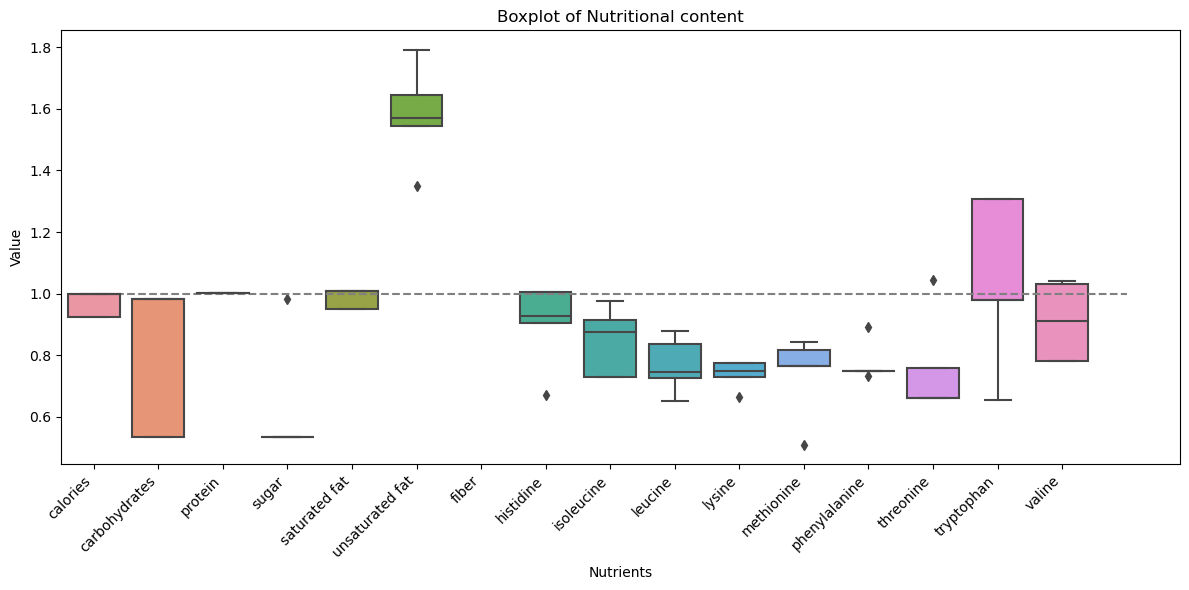

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Rearrange DataFrame to long format
melted_df = df_percentage[cols_present].melt(var_name='Nutrients', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Nutrients', y='Value', data=melted_df)
plt.hlines(1,0, len(cols_present),colors='grey',linestyles='dashed')
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Nutritional content')
plt.tight_layout()
# plt.ylim([0,2.56])
plt.show()


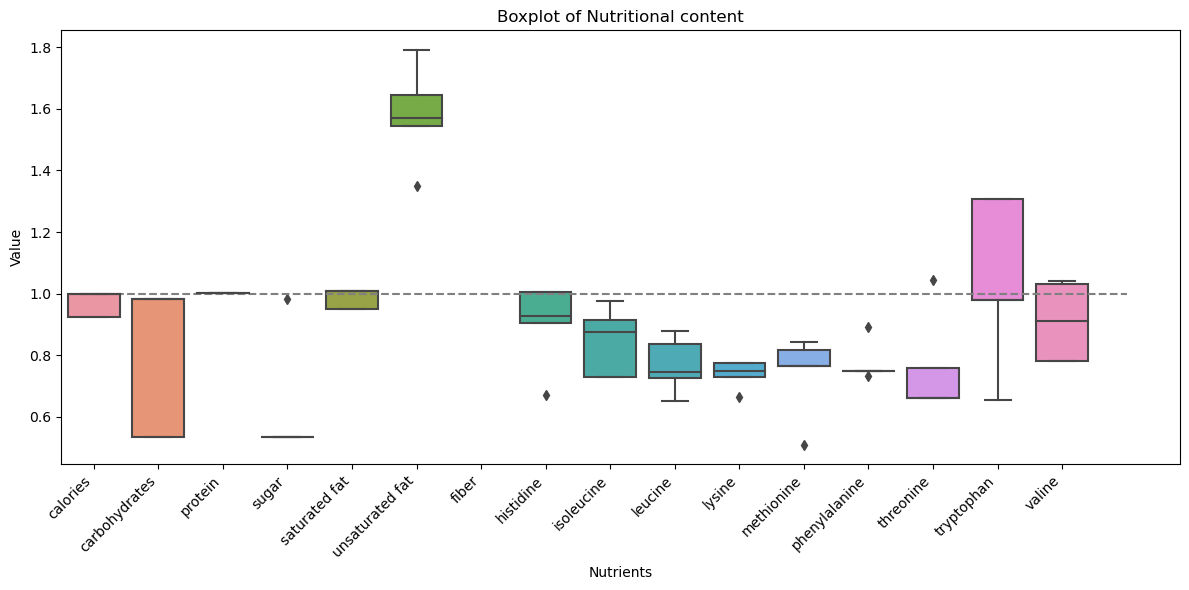

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Rearrange DataFrame to long format
melted_df = df_percentage[cols_present].melt(var_name='Nutrients', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Nutrients', y='Value', data=melted_df)
plt.hlines(1,0, len(cols_present),colors='grey',linestyles='dashed')
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Nutritional content')
plt.tight_layout()
# plt.ylim([0,2.56])
plt.show()


# WORKING IMPLEMENTATION WIHT JSON OUTPUT

In [386]:

weight = 100
name = 'whole hard-boiled egg'
prompt = f"""Lets play a game: Lets see if we can estomate nutrients from {weight}g of a standard "{name}". Give me the numbers for the following variables:
          'calories', 'water','carbohydrates','protein','fat','saturated fat','unsaturated fat','sugar','glucose','fructose','lactose',galactose, 'glycemic index', fiber,'soluble fiber','insoluble fiber','iron','essential amino acids', 'nonessential amino acids','histidine','isoleucine', 'leucine', 'lysine', 'methionine','phenylalanine','threonine','tryptophan','valine'.
          please give the output in json format with the quantities in grams where possible. 
          """


from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
    model="gpt-3.5-turbo-1106", #gpt-3.5-turbo-1106 "gpt-4" gpt-4-0613
  messages=[
    {
      "role": "user",
      "content": prompt
    }
  ],
  temperature=1,
  max_tokens=512,
  top_p=1,
  n=5,
  frequency_penalty=0,
  presence_penalty=0,
  response_format={ "type": "json_object"},
)

print(response.choices[0].message.content)

{
  "calories": 155,
  "carbohydrates": 0.6,
  "protein": 12.6,
  "fat": 10.6,
  "saturated fat": 3.3,
  "unsaturated fat": 5.5,
  "sugar": 0.6,
  "glucose": 0.2,
  "fructose": 0.2,
  "lactose": 0.1,
  "galactose": 0.2,
  "glycemic index": 0,
  "fiber": 0,
  "soluble fiber": 0,
  "insoluble fiber": 0,
  "iron": 1.1,
  "histidine": 0.3,
  "isoleucine": 0.5,
  "leucine": 0.8,
  "lysine": 0.7,
  "methionine": 0.3,
  "phenylalanine": 0.5,
  "threonine": 0.4,
  "tryptophan": 0.1,
  "valine": 0.6
}


In [405]:
import pandas as pd

def compare_jsons(response, json_outputted=False):
    # Create an empty list to store the flattened DataFrames
    dfs = []

    # Loop over each JSON object in the list
    for i, api_response in enumerate(response.choices):
        if json_outputted is False:

            
            json_obj = preprocess_and_load_json(response.choices[i].message.content)



        else:
            json_str = api_response.message.content
            json_obj = json.loads(json_str)        # Flatten the JSON object
        flattened = pd.json_normalize(json_obj)
        # print('flattened',flattened)

        for col in flattened.columns:
            flattened[col] = pd.to_numeric(flattened[col], errors='coerce')

        flattened.columns = [col.split('.')[-1] for col in flattened.columns]
        flattened.columns = flattened.columns.str.lower() #lowercase

        # Add the flattened DataFrame to the list
        dfs.append(flattened)

    # Concatenate all DataFrames in the list
    main_df = pd.concat(dfs, ignore_index=True)

    return main_df


df = compare_jsons(response, json_outputted=False)
df


ic| 'json_obj': 'json_obj'
    json_obj: {'llm_output': 'I can provide a general estimate based on typical values for a '
                             'simple cracker, but please be aware that the exact nutritional '
                             'content can vary significantly depending on the brand and '
                             'recipe of the cracker. My estimation will be for a single '
                             'average-sized plain cracker, which typically weighs around 5 '
                             'to 10 grams.
              '
                             '
              '
                             "Here's the estimated nutritional content in JSON format:
              "
                             '
              '
                             '```json
              '
                             '{
              '
                             '  "calories": 20-40,
              '
                             '  "water": "Trace amounts",
              '
           

,llm_output
0,NaN


# FoodData Central API

In [384]:
import requests
import json

api_key = 'BHb9j4DzG3sXcbvFElzdwwER0Kp5hU1ILRmzaAc3'
food_name = 'Nuts, walnuts, black, dried'  # Replace with the desired food name
food_name = 'Egg, whole, cooked, hard-boiled'
# Make a request to the Food Search endpoint to get the food ID
search_response = requests.get('https://api.nal.usda.gov/fdc/v1/foods/search?api_key=' + api_key + '&query=' + food_name)
search_results = json.loads(search_response.text)
food_id = search_results['foods'][0]['fdcId']  # Assuming the first result is the desired food

# Make a request to the Food Details endpoint to get the nutrient information
details_response = requests.get('https://api.nal.usda.gov/fdc/v1/food/' + str(food_id) + '?api_key=' + api_key)
nutrient_info = json.loads(details_response.text)

# Process and use the nutrient_info as needed
nutrient_info

In [385]:
nutrient_info

{'fdcId': 173424,
 'description': 'Egg, whole, cooked, hard-boiled',
 'publicationDate': '4/1/2019',
 'foodNutrients': [{'nutrient': {'id': 2045,
    'number': '951',
    'name': 'Proximates',
    'rank': 50,
    'unitName': 'g'},
   'type': 'FoodNutrient'},
  {'type': 'FoodNutrient',
   'nutrient': {'id': 1051,
    'number': '255',
    'name': 'Water',
    'rank': 100,
    'unitName': 'g'},
   'id': 1777903,
   'amount': 74.62,
   'dataPoints': 14},
  {'type': 'FoodNutrient',
   'nutrient': {'id': 1008,
    'number': '208',
    'name': 'Energy',
    'rank': 300,
    'unitName': 'kcal'},
   'foodNutrientDerivation': {'id': 49,
    'code': 'NC',
    'description': 'Calculated',
    'foodNutrientSource': {'id': 2,
     'code': '4',
     'description': 'Calculated or imputed'}},
   'id': 1777847,
   'amount': 155.0,
   'dataPoints': 0},
  {'type': 'FoodNutrient',
   'nutrient': {'id': 1062,
    'number': '268',
    'name': 'Energy',
    'rank': 400,
    'unitName': 'kJ'},
   'id': 1777844

In [388]:
essential_amino_acids = [
        "histidine",
        "isoleucine",
        "leucine",
        "lysine",
        "methionine",
        "phenylalanine",
        "threonine",
        "tryptophan",
        "valine"
    ]

non_essential_amino_acids = [
    "alanine", 
"arginine", 
"asparagine", 
"aspartic acid", 
"cysteine", 
"glutamic acid", 
"glutamine", 
"glycine", 
"proline", 
"serine", 
"tyrosine"
]

macros = ['protein', 'sucrose','glucose','fructose','water']

nutrition_scaled_dict = {'unsaturated fat': 0}


# Loop over the items in nutrient_info['foodNutrients']
for nutrient in nutrient_info['foodNutrients']:
    # Get the nutrient name in lowercase
    nutrient_name = nutrient['nutrient']['name'].lower()
    # Check if the nutrient is an essential or non-essential amino acid
    if nutrient_name in essential_amino_acids or nutrient_name in non_essential_amino_acids or nutrient_name in macros:
        # Add the nutrient name and its amount to the dictionary
        nutrition_scaled_dict[nutrient_name] = nutrient['amount']

    elif (nutrient_name =='energy') & (nutrient['nutrient']['unitName'] == 'kcal'):
        nutrition_scaled_dict['calories'] = nutrient['amount']
    elif nutrient_name =='fiber, total dietary':
        nutrition_scaled_dict['fiber'] = nutrient['amount']
    elif nutrient_name =='total sugars':
        nutrition_scaled_dict['sugar'] = nutrient['amount']
    elif nutrient_name =='total lipid (fat)':
        nutrition_scaled_dict['fat'] = nutrient['amount']
    elif nutrient_name =='carbohydrate, by difference':
        nutrition_scaled_dict['carbohydrates'] = nutrient['amount']
    elif nutrient_name == 'fatty acids, total saturated':
        nutrition_scaled_dict['saturated fat'] = nutrient['amount']
    elif nutrient_name == 'fatty acids, total monounsaturated': # fatty acids, total polyunsaturated
        try:
            nutrition_scaled_dict['unsaturated fat'] = nutrition_scaled_dict['unsaturated fat']  + nutrient['amount'] #+ 
        except:
            continue


# List of keys you're interested in
macros_plus = ['calories', 'water', 'carbohydrates', 'protein', ' fat', 'sugar', 'fructose','glucose','lactose','saturated fat', 'unsaturated fat', 'fiber'] 
essential_amino_acids 
keys_of_interest = macros_plus + essential_amino_acids


# Subselect key-value pairs
final_nutrients_dict = {k: nutrition_scaled_dict[k] for k in keys_of_interest if k in nutrition_scaled_dict}

# now calculate the % grams of amino acids from the chatgpt output with the        
df_percentage = df.copy()

cols_present = final_nutrients_dict.keys()


for col in cols_present:
    if col in df.columns:
        df_percentage[col] = df[col]/final_nutrients_dict[col]
        print(col)
df_percentage[cols_present]

calories
carbohydrates
protein
sugar
saturated fat
unsaturated fat
fiber
histidine
isoleucine
leucine
lysine
methionine
phenylalanine
threonine
tryptophan
valine


,calories,carbohydrates,protein,sugar,saturated fat,unsaturated fat,fiber,histidine,isoleucine,leucine,lysine,methionine,phenylalanine,threonine,tryptophan,valine
0,1.000000,0.535714,1.00159,0.535714,1.010101,1.349031,NaN,1.006711,0.728863,0.744186,0.774336,0.765306,0.748503,0.662252,0.653595,0.782269
1,0.922581,0.982143,1.00159,0.535714,0.948883,1.545254,NaN,1.006711,0.874636,0.837209,0.774336,0.765306,0.748503,0.662252,1.307190,0.912647
2,1.000000,0.982143,1.00159,0.982143,1.010101,1.790532,NaN,0.906040,0.976676,0.725581,0.730088,0.816327,0.733533,1.043046,0.980392,1.029987
3,1.000000,0.535714,1.00159,0.535714,1.010101,1.643365,NaN,0.926174,0.915452,0.878140,0.750000,0.844388,0.890719,0.758278,0.980392,1.041721
4,0.922581,0.982143,1.00159,0.535714,0.948883,1.569782,NaN,0.671141,0.728863,0.651163,0.663717,0.510204,0.748503,0.662252,1.307190,0.782269


In [391]:
df

,calories,carbohydrates,protein,fat,saturated fat,unsaturated fat,sugar,glucose,fructose,lactose,galactose,glycemic index,fiber,soluble fiber,insoluble fiber,iron,histidine,isoleucine,leucine,lysine,methionine,phenylalanine,threonine,tryptophan,valine
0,155,0.6,12.6,10.6,3.3,5.5,0.6,0.2,0.2,0.1,0.2,0,0,0,0,1.1,0.300,0.500,0.800,0.700,0.300,0.500,0.400,0.10,0.600
1,143,1.1,12.6,9.5,3.1,6.3,0.6,0.2,0.2,0.1,0.2,0,0,0,0,1.8,0.300,0.600,0.900,0.700,0.300,0.500,0.400,0.20,0.700
2,155,1.1,12.6,10.6,3.3,7.3,1.1,0.0,0.0,0.0,0.0,0,0,0,0,1.7,0.270,0.670,0.780,0.660,0.320,0.490,0.630,0.15,0.790
3,155,0.6,12.6,10.6,3.3,6.7,0.6,0.0,0.0,0.0,0.0,0,0,0,0,1.0,0.276,0.628,0.944,0.678,0.331,0.595,0.458,0.15,0.799
4,143,1.1,12.6,9.5,3.1,6.4,0.6,0.0,0.0,0.0,0.0,0,0,0,0,1.2,0.200,0.500,0.700,0.600,0.200,0.500,0.400,0.20,0.600


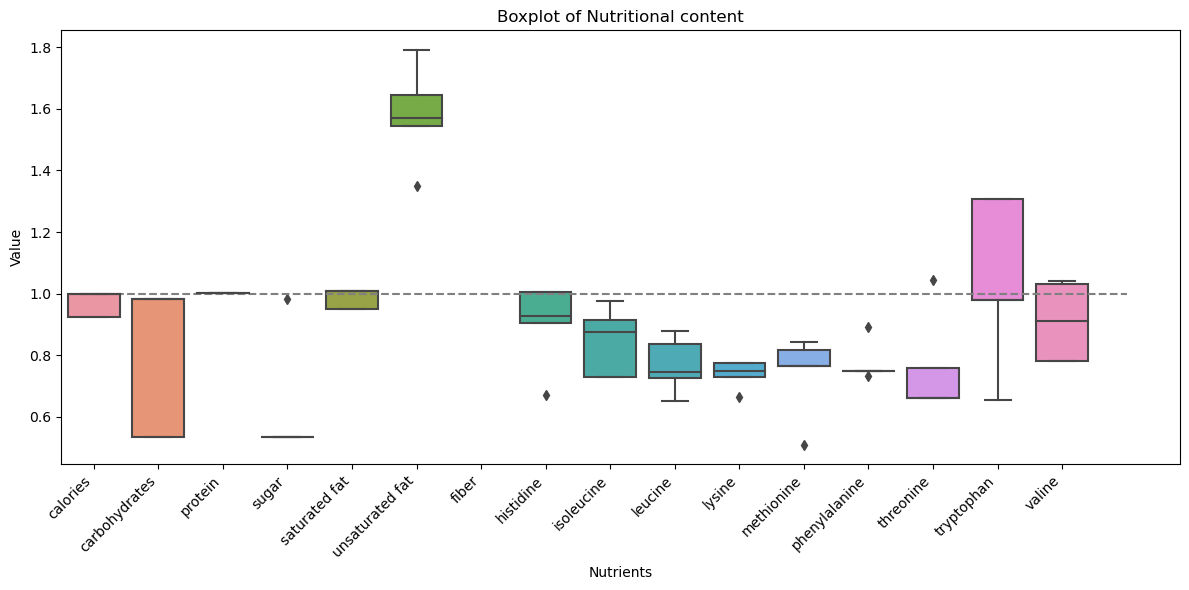

In [389]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Rearrange DataFrame to long format
melted_df = df_percentage[cols_present].melt(var_name='Nutrients', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Nutrients', y='Value', data=melted_df)
plt.hlines(1,0, len(cols_present),colors='grey',linestyles='dashed')
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Nutritional content')
plt.tight_layout()
# plt.ylim([0,2.56])
plt.show()


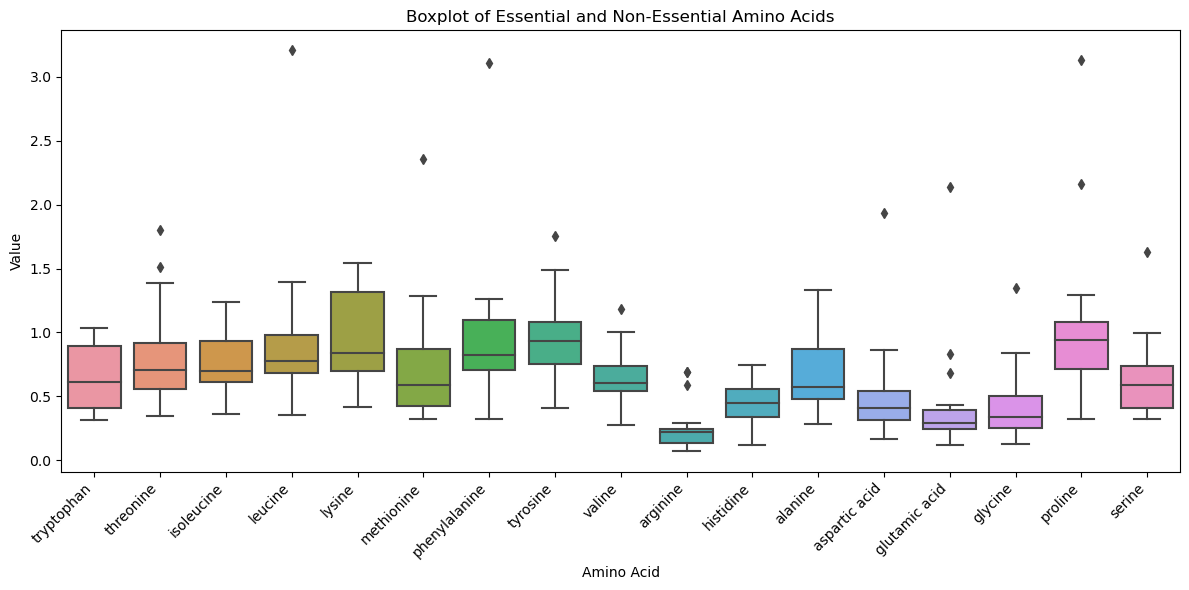

In [188]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Rearrange DataFrame to long format
melted_df = df_percentage[cols_present].melt(var_name='Amino Acid', value_name='Value')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Amino Acid', y='Value', data=melted_df)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Essential and Non-Essential Amino Acids')
plt.tight_layout()
plt.show()

In [322]:
df_percentage_all.to_csv('data/saved/walnuts macros kernel only_as perc of FoodData_n25_gpt4')  #gpt35_turbo.csv')

,tryptophan,threonine,isoleucine,leucine,lysine,methionine,phenylalanine,tyrosine,valine,arginine,histidine,alanine,aspartic acid,glutamic acid,glycine,proline,serine
0,0.556604,0.907074,0.777433,1.017815,0.901823,0.563169,1.119744,0.835135,0.671125,0.699005,0.842262,0.584924,0.453761,0.543284,0.523129,0.747300,0.575510
1,0.786164,1.484050,1.231884,1.526128,1.234222,1.241970,1.261426,1.662162,1.062156,0.693753,0.922619,1.135496,1.200164,1.187888,1.471825,1.436285,1.093878


In [189]:
nutrient_info['servingSize']
# nutrient_info['foodNutrients']

KeyError: 'servingSize'

In [191]:
nutrient_info.keys()

dict_keys(['fdcId', 'footnote', 'description', 'publicationDate', 'foodNutrients', 'foodPortions', 'dataType', 'foodClass', 'scientificName', 'foodComponents', 'foodAttributes', 'nutrientConversionFactors', 'inputFoods', 'ndbNumber', 'isHistoricalReference', 'foodCategory'])

In [192]:
nutrient_info['foodPortions']

[{'id': 86200,
  'gramWeight': 28.35,
  'sequenceNumber': 3,
  'amount': 1.0,
  'modifier': 'oz',
  'measureUnit': {'id': 9999,
   'name': 'undetermined',
   'abbreviation': 'undetermined'}},
 {'id': 86199,
  'gramWeight': 7.8,
  'sequenceNumber': 2,
  'amount': 1.0,
  'modifier': 'tbsp',
  'measureUnit': {'id': 9999,
   'name': 'undetermined',
   'abbreviation': 'undetermined'}},
 {'id': 86198,
  'gramWeight': 125.0,
  'sequenceNumber': 1,
  'amount': 1.0,
  'modifier': 'cup, chopped',
  'measureUnit': {'id': 9999,
   'name': 'undetermined',
   'abbreviation': 'undetermined'}}]

In [93]:
response.choices[0].message.content


'{\n  "glycemic index": "Low (approximately 15-20)",\n  "essential amino acids": {\n    "histidine": "0.566",\n    "isoleucine": "0.751",\n    "leucine": "1.714",\n    "lysine": "0.643",\n    "methionine": "0.263",\n    "phenylalanine": "1.225",\n    "threonine": "0.654",\n    "tryptophan": "0.177",\n    "valine": "0.853"\n  },\n  "non essential amino acids": {\n    "alanine": "0.613",\n    "arginine": "2.529",\n    "asparagine": "N/A",\n    "aspartic acid": "1.104",\n    "cysteine": "0.143",\n    "glutamic acid": "2.799",\n    "glutamine": "N/A",\n    "glycine": "0.622",\n    "proline": "0.692",\n    "serine": "0.705",\n    "tyrosine": "0.618"\n  }\n}'

In [97]:
response.choices[0].message.content


'{\n  "glycemic index": "Low (approximately 15-20)",\n  "essential amino acids": {\n    "histidine": "0.566",\n    "isoleucine": "0.751",\n    "leucine": "1.714",\n    "lysine": "0.643",\n    "methionine": "0.263",\n    "phenylalanine": "1.225",\n    "threonine": "0.654",\n    "tryptophan": "0.177",\n    "valine": "0.853"\n  },\n  "non essential amino acids": {\n    "alanine": "0.613",\n    "arginine": "2.529",\n    "asparagine": "N/A",\n    "aspartic acid": "1.104",\n    "cysteine": "0.143",\n    "glutamic acid": "2.799",\n    "glutamine": "N/A",\n    "glycine": "0.622",\n    "proline": "0.692",\n    "serine": "0.705",\n    "tyrosine": "0.618"\n  }\n}'

In [42]:
json_out = preprocess_and_load_json(text)

In [43]:
json_out

{'llm_output': '{\n  "glycemic index": 34,\n  "essential amino acids": {\n    "histidine": 0.63,\n    "isoleucine": 1.1,\n    "leucine": 1.9,\n    "lysine": 1.3,\n    "methionine": 0.35,\n    "phenylalanine": 1.1,\n    "threonine": 0.86,\n    "tryptophan": 0.2,\n    "valine": 1.1\n  },\n  "non essential amino acids": {\n    "alanine": 0.75,\n    "arginine": 1.04,\n    "asparagine": 1.3,\n    "aspartic acid": 1.74,\n    "cysteine": 0.22,\n    "glutamic acid": 5.54,\n    "glutamine": 3.95,\n    "glycine": 0.52,\n    "proline": 3.5,\n    "serine": 1.08,\n    "tyrosine": 0.7\n  }\n}',
 'glycemic index': 34,
 'histidine': 0,
 'isoleucine': 1,
 'leucine': 1,
 'lysine': 1,
 'methionine': 0,
 'phenylalanine': 1,
 'threonine': 0,
 'tryptophan': 0,
 'valine': 1}

In [19]:
name

'Apricots, dried'